# Поиск ключевых слов для медицинских статей

Идея подхода заключается в применения TF-IDF к корпусу текстов, принадлежащих к одной теме. TF-IDF выделит ключевые слова, характеризующие уникальность каждого текста

## Загрузка библиотек

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

 Anomaly.ipynb
 bert_classif.ipynb
'bert+lstm(окончат).ipynb'
 bert_ner
 BERT_Tutorial.ipynb
' BILSTM_all_entities__.ipynb'
 BILSTM_.ipynb
 BiLSTM_prob.ipynb
 BIO_preprocessing.ipynb
'Colab Notebooks'
 CPD.ipynb
 CRF.ipynb
 csv-xml.ipynb
 data_all.pkl
 data_onlyI.pkl
 data_withBI.pickle
 dict_tegsB.pkl
 dict_tegs.pkl
 dict_wordsB.pkl
 dict_words.pkl
 English.gsheet
 Homework#3.ipynb
 Kate
 keras.ipynb
 Lab1_3.ipynb
 Lab7.ipynb
 Laba_4.ipynb
'NYTimes: Throughout Trial Over George Floyd’s Death, Killings by Police Mount'
 PROJECT_TS
 reg.gsheet
 SD_1.ipynb
 SD_2.ipynb
 SD_3.ipynb
'Slang by victoria_mrmr.pdf'
 Spark_.ipynb
 Untitled
 Untitled0.ipynb
'Untitled (1)'
'Untitled (10)'
 Untitled10.ipynb
'Untitled (11)'
 Untitled11.ipynb
 Untitled12.ipynb
 Untitled13.ipynb
 Untitled14.ipynb
 Untitled15.ipynb
 Untitled16.ipynb
 Untitled17.ipynb
 Untitled18.ipynb
 Untitled19.ipynb
 Untitled1.ipynb
'Untitled (2)'
 Untitled20.ipynb
 Untitled21.ipynb
 Untitled22.ipynb
 Untitled23.ipynb
 Untitled24.ip

In [ ]:
cd /content/drive/My Drive

/content/drive/My Drive


In [ ]:
cd 'Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
cd bert

/content/drive/My Drive/Colab Notebooks/bert


In [ ]:
ls

 BART.ipynb                    segments.ipynb
 Bert_embeddings.ipynb         sort_bars_in_barplot_ascending_order_Seaborn_Python.png
'BERT+Lstm(end).ipynb'         sumarization.ipynb
' "BERT+Lstm(end)News'         tf-idf.ipynb
'"BERT+Lstm(end). отзывы'      vectorizer.joblib
'BERT+Lstm(end)эксперемент'    Датасеты/
 bert_lstm.ipynb              'Копия блокнота "bert+lstm(окончат).ipynb"'
 bert_model                    модель/
 blue_bert_all.npy            'Новый датасет'/
 Classification_emb.ipynb     '"получение_эмбеддингов.ipynb""'
 df_all.pickle                'Понижение_разм_визуализация (мед статьи)'
 df_test_true.pkl             'Понижение_разм_визуализация (новости)'
 df_train_true.pkl            'Понижение_разм_визуализация (новый датасет)'
 embeddings_test.npy          'Понижение_разм_визуализация (отывы).ipynb'
 embeddings_train.npy          Приложение/
 index.html                    Результаты.gsheet
 KNN_transformer.ipynb         Эмбеддинги/
'Padding_emb (мед.тексты)'    

## Загрузка данных

В качестве набора данных используются данные медицинских статей, полученные с платформы Arxiv.org


[Ссылка](https://www.kaggle.com/datasets/ekaterinamayatskaya/medical-articles)

In [ ]:
df = pd.read_pickle('Приложение/df_new_10.pkl')

In [ ]:
df

,Название статьи,Абстракт,Ссылка,Метка,length
0,RECOVER: sequential model optimization platfor...,"For large libraries of small molecules, exhaus...",https://arxiv.org/abs/2202.04202,Cancer,236.0
1,Unsupervised heart abnormality detection based...,Heart Sound (also known as phonocardiogram (PC...,https://arxiv.org/abs/2101.05443,cardiovascular,156.0
2,"Modularity ""for free"" in genome architecture?",Background: Recent models of genome-proteome e...,https://arxiv.org/abs/q-bio/0312032,genetics,203.0
3,Representing and extracting knowledge from sin...,Single-cell analysis is currently one of the m...,https://arxiv.org/abs/2304.13084,genetics,162.0
4,Predicted disease compositions of human glioma...,Background and Purpose: Biopsy is the main det...,https://arxiv.org/abs/1908.02334,Cancer,250.0
...,...,...,...,...,...
18967,Unveiling the mystery of visual information pr...,It is generally accepted that human vision is ...,https://arxiv.org/abs/0807.0337,brain disease,238.0
18968,On the Impact of Mutation-Selection Balance on...,The interplay between mutation and selection p...,https://arxiv.org/abs/1012.3098,genetics,195.0
18969,Improving Prognostic Performance in Resectable...,As an analytic pipeline for quantitative imagi...,https://arxiv.org/abs/1907.04822,Cancer,214.0
18970,Analysis of DNA sequence variation within mari...,We apply recently developed inference methods ...,https://arxiv.org/abs/1209.0813,DNA/RNA,121.0


## Предобработка данных

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

In [ ]:
import re

In [ ]:
sw = stopwords.words('english')

def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) #Замена всего пробелами, кроме (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Удаление URLs

    html=re.compile(r'<.*?>')

    text = html.sub(r'',text) #Удаление html tags

    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Удаление пунктуации

    text = [word.lower() for word in text.split() if word.lower() not in sw]

    text = " ".join(text) #Удаляем стоп слова

    return text

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer

def lem(text):
    # Создание экземпляра класса WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    # Лемматизация каждого слова в корпусе
    lemmatized_corpus = [lemmatizer.lemmatize(word) for word in text]

    return lemmatized_corpus

In [ ]:
df['Абстракт'] = df['Абстракт'].apply(lambda x: clean_text(x))

In [ ]:
df['Абстракт'] = df['Абстракт'].apply(lambda x: lem(x))

In [ ]:
def join_sent(text):
  text=' '.join(text)
  return text

In [ ]:
df['Абстракт'] = df['Абстракт'].apply(lambda x: join_sent(x))

## TF-IDF

In [ ]:
# Функция извлечения текста
def extract(df, name):
    texts=[]
    for i in range(len(df['Абстракт'])):
        if df['Метка'][i] == name:
            texts.append(df['Абстракт'][i])
    return texts


In [ ]:
# Функция извлечения меток
def extract_label(df, name):
    label=[]
    for i in range(len(df['Абстракт'])):
        if df['Метка'][i] == name:
            label.append(df['Метка'][i])
    return label

In [ ]:
def sort_coo(coo_matrix):
    """Сортируем словарь"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """Вывод найденных слов и важности найденных с помощью tf-idf"""

    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    # индекс слова и соответствующий балл tf-idf
    for idx, score in sorted_items:

        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]

    return results

In [ ]:
TOP_K_KEYWORDS = 5

In [ ]:
def get_keywords(vectorizer, feature_names, doc):
    """Возвращает топ k ключевых слов, найденных TF-IDF"""

    # генерация tf-idf для данного документа
    tf_idf_vector = vectorizer.transform([doc])

    # сортировка векторов tf-idf в порядке убывания оценок
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    # вывод определенного (TOP_K_KEYWORDS) колличества значимых слов
    keywords=extract_topn_from_vector(feature_names,sorted_items,TOP_K_KEYWORDS)

    return list(keywords.keys()),  list(keywords.items())

Применение метода к корпусу текстов с меткой - Cancer

In [ ]:
cancer_texts = extract(df,'Cancer')

In [ ]:
cancer_labels = extract_label(df,'Cancer')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)

vectorizer.fit_transform(cancer_texts)

feature_names = vectorizer.get_feature_names_out()

Сохранение векторизатора

In [ ]:
from joblib import dump
from joblib import load

In [ ]:
dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

In [ ]:
vectorizer1 = load('vectorizer.joblib')

### Вывод ключевых слов

In [ ]:
result = []
for doc in cancer_texts:
    df1 = {}
    df1['full_text'] = doc
    df1['top_keywords'] = get_keywords(vectorizer, feature_names, doc)[0]
    result.append(df1)

final = pd.DataFrame(result)
final

,full_text,top_keywords
0,"large library small molecules, exhaustive comb...","[round, synergistic, combination, drug, search]"
1,background purpose biopsy main determinant gli...,"[voxel, weighted, pdc, mri, wise]"
2,two model circulating tumor cell ctc dynamic p...,"[seeding, primary, secondary, ctc, shed]"
3,breast cancer disease threatens many woman lif...,"[impedance, last, breast, technique, mentioned]"
4,effect emotion personalisation continuance use...,"[personalisation, intention, emotion, reuse, w..."
...,...,...
3370,"interstitial fluid pressure ifp , interstitial...","[fluid, ifp, pressure, poroelastography, vp]"
3371,finding cancer driver gene focal theme cancer ...,"[ckgs, blca, control, gene, driver]"
3372,computational model simulation appealing intri...,"[simulation, calibration, scale, across, compi..."
3373,skin cancer prevalent potentially fatal diseas...,"[vit, finetuned, segmentation, mean, skin]"


In [ ]:
values = []
for doc in cancer_texts:
    df1 = {}
    df1['full_text'] = doc
    df1['top_keywords'] = get_keywords(vectorizer, feature_names, doc)[1]
    values.append(df1)

value_df = pd.DataFrame(values)
value_df

,full_text,top_keywords
0,"large library small molecules, exhaustive comb...","[(round, 0.359), (synergistic, 0.297), (combin..."
1,background purpose biopsy main determinant gli...,"[(voxel, 0.296), (weighted, 0.291), (pdc, 0.20..."
2,two model circulating tumor cell ctc dynamic p...,"[(seeding, 0.508), (primary, 0.381), (secondar..."
3,breast cancer disease threatens many woman lif...,"[(impedance, 0.245), (last, 0.235), (breast, 0..."
4,effect emotion personalisation continuance use...,"[(personalisation, 0.491), (intention, 0.468),..."
...,...,...
3370,"interstitial fluid pressure ifp , interstitial...","[(fluid, 0.464), (ifp, 0.335), (pressure, 0.28..."
3371,finding cancer driver gene focal theme cancer ...,"[(ckgs, 0.41), (blca, 0.328), (control, 0.302)..."
3372,computational model simulation appealing intri...,"[(simulation, 0.318), (calibration, 0.216), (s..."
3373,skin cancer prevalent potentially fatal diseas...,"[(vit, 0.467), (finetuned, 0.264), (segmentati..."


In [ ]:
values = []
for doc in cancer_texts:
    df1 = {}
    df1['Full_text'] = doc
    # df1['Метка'] = cancer_labels
    df1['Word 1'] = get_keywords(vectorizer, feature_names, doc)[1][0][0]
    df1['Word 2'] = get_keywords(vectorizer, feature_names, doc)[1][1][0]
    df1['Word 3'] = get_keywords(vectorizer, feature_names, doc)[1][2][0]
    df1['Word 4'] = get_keywords(vectorizer, feature_names, doc)[1][3][0]
    df1['Word 5'] = get_keywords(vectorizer, feature_names, doc)[1][4][0]
    values.append(df1)

value_df = pd.DataFrame(values)
value_df

,Full_text,Word 1,Word 2,Word 3,Word 4,Word 5
0,"large library small molecules, exhaustive comb...",round,synergistic,combination,drug,search
1,background purpose biopsy main determinant gli...,voxel,weighted,pdc,mri,wise
2,two model circulating tumor cell ctc dynamic p...,seeding,primary,secondary,ctc,shed
3,breast cancer disease threatens many woman lif...,impedance,last,breast,technique,mentioned
4,effect emotion personalisation continuance use...,personalisation,intention,emotion,reuse,website
...,...,...,...,...,...,...
3370,"interstitial fluid pressure ifp , interstitial...",fluid,ifp,pressure,poroelastography,vp
3371,finding cancer driver gene focal theme cancer ...,ckgs,blca,control,gene,driver
3372,computational model simulation appealing intri...,simulation,calibration,scale,across,compiles
3373,skin cancer prevalent potentially fatal diseas...,vit,finetuned,segmentation,mean,skin


In [ ]:
top_k = value_df['top_keywords'][3371]

In [ ]:
top_k

[('ckgs', 0.41),
 ('blca', 0.328),
 ('control', 0.302),
 ('gene', 0.272),
 ('driver', 0.199)]

In [ ]:
labels, values = zip(*top_k)

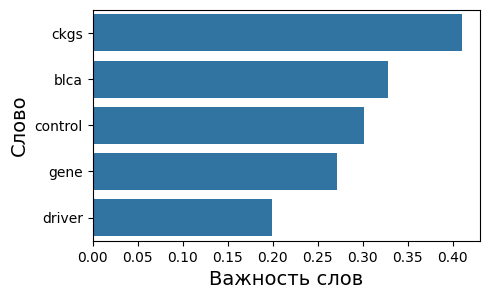

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(x=values, y=labels)
plt.xlabel('Важность слов', fontsize=14)
plt.ylabel('Слово', fontsize=14)
# plt.title('', fontsize=16)
plt.show()

In [ ]:
top_k = value_df['top_keywords'][3373]

In [ ]:
top_k

[('vit', 0.467),
 ('finetuned', 0.264),
 ('segmentation', 0.199),
 ('mean', 0.189),
 ('skin', 0.166)]

In [ ]:
labels, values = zip(*top_k)

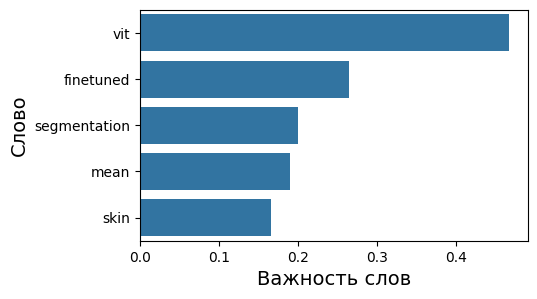

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(x=values, y=labels)
plt.xlabel('Важность слов', fontsize=14)
plt.ylabel('Слово', fontsize=14)
# plt.title('', fontsize=16)
plt.show()

##Genetics

Вывод значимых слов для текстов, связанных с генетикой

In [ ]:
genetics_texts = extract(df,'genetics')[:3500]

In [ ]:
len(genetics_texts)

3500

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)

vectorizer.fit_transform(genetics_texts)

# Storing vocab
feature_names = vectorizer.get_feature_names_out()

In [ ]:
result = []
for doc in genetics_texts:
    df1 = {}
    df1['full_text'] = doc
    df1['top_keywords'] = get_keywords(vectorizer, feature_names, doc)[0]
    result.append(df1)

final = pd.DataFrame(result)
final

,full_text,top_keywords
0,background recent model genome proteome evolut...,"[dd, free, transition, close, proteome]"
1,single cell analysis currently one high resolu...,"[statistic, biology, single, analysis, cell]"
2,problem controlling mean variance specie inter...,"[pi, controller, variance, moment, mean]"
3,multi cell biochemical assay single cell fluor...,"[elongation, polii, mobility, local, active]"
4,persistent homology computes topological invar...,"[invariant, topological, cloud, computes, infl..."
...,...,...
3495,"paper, consider two stochastic model gene expr...","[type, inducer, level, state, protein]"
3496,"naive human cell produced thymus, atrophy abru...","[clone, production, eigenvalue, abundance, cell]"
3497,reconsider deterministic haploid mutation sele...,"[ancestral, deterministic, equation, type, graph]"
3498,ability precisely edit genome deleting adding ...,"[hr, yeast, nhej, engineering, host]"


In [ ]:
values = []
for doc in genetics_texts:
    df1 = {}
    df1['Full_text'] = doc
    df1['Word 1'] = get_keywords(vectorizer, feature_names, doc)[1][0][0]
    df1['Word 2'] = get_keywords(vectorizer, feature_names, doc)[1][1][0]
    df1['Word 3'] = get_keywords(vectorizer, feature_names, doc)[1][2][0]
    df1['Word 4'] = get_keywords(vectorizer, feature_names, doc)[1][3][0]
    df1['Word 5'] = get_keywords(vectorizer, feature_names, doc)[1][4][0]
    values.append(df1)

value_df = pd.DataFrame(values)
value_df

,Full_text,Word 1,Word 2,Word 3,Word 4,Word 5
0,background recent model genome proteome evolut...,dd,free,transition,close,proteome
1,single cell analysis currently one high resolu...,statistic,biology,single,analysis,cell
2,problem controlling mean variance specie inter...,pi,controller,variance,moment,mean
3,multi cell biochemical assay single cell fluor...,elongation,polii,mobility,local,active
4,persistent homology computes topological invar...,invariant,topological,cloud,computes,influenza
...,...,...,...,...,...,...
3495,"paper, consider two stochastic model gene expr...",type,inducer,level,state,protein
3496,"naive human cell produced thymus, atrophy abru...",clone,production,eigenvalue,abundance,cell
3497,reconsider deterministic haploid mutation sele...,ancestral,deterministic,equation,type,graph
3498,ability precisely edit genome deleting adding ...,hr,yeast,nhej,engineering,host


In [ ]:
top_k = value_df['top_keywords'][3499]

In [ ]:
top_k

[('mutation', 0.4),
 ('cell', 0.315),
 ('accumulation', 0.221),
 ('population', 0.212),
 ('risk', 0.21)]

In [ ]:
labels, values = zip(*top_k)

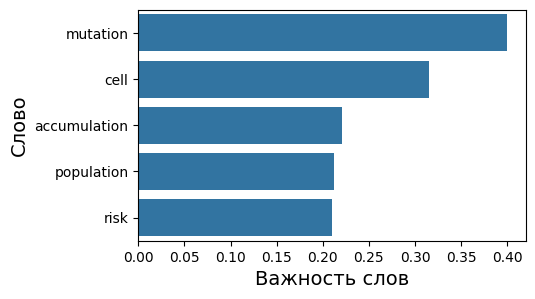

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(x=values, y=labels)
plt.xlabel('Важность слов', fontsize=14)
plt.ylabel('Слово', fontsize=14)
# plt.title('', fontsize=16)
plt.show()

In [ ]:
top_k = value_df['top_keywords'][3498]

In [ ]:
top_k

[('hr', 0.556),
 ('yeast', 0.316),
 ('nhej', 0.292),
 ('engineering', 0.186),
 ('host', 0.166)]

In [ ]:
labels, values = zip(*top_k)

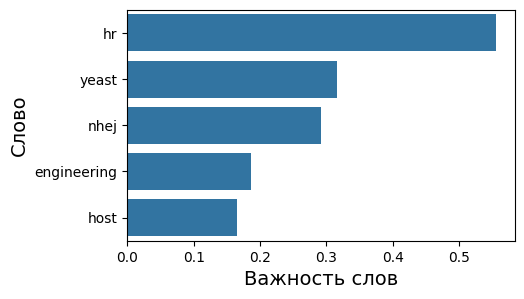

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(x=values, y=labels)
plt.xlabel('Важность слов', fontsize=14)
plt.ylabel('Слово', fontsize=14)
# plt.title('', fontsize=16)
plt.show()

## DNA/RNA

In [ ]:
dna_texts = extract(df,'DNA/RNA')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)

vectorizer.fit_transform(dna_texts)

# Storing vocab
feature_names = vectorizer.get_feature_names_out()

In [ ]:
result = []
for doc in dna_texts:
    df1 = {}
    df1['full_text'] = doc
    df1['top_keywords'] = get_keywords(vectorizer, feature_names, doc)[0]
    result.append(df1)

final = pd.DataFrame(result)
final

,full_text,top_keywords
0,"obtain, using transfer matrix methods, distrib...","[loop, formation, probability, bubble, extension]"
1,consistently predicting biopolymer structure a...,"[swa, residue, loop, stepwise, modeling]"
2,hypothesis phase transition originate topologi...,"[hypersurface, receives, evident, originate, p..."
3,gene regulation involves hierarchy event exten...,"[regulation, fold, gene, approach, extremes]"
4,high throughput rna sequencing rna seq emerged...,"[de, bdseq, uncertainty, isoforms, detecting]"
...,...,...
1645,quantitative understanding principle regulatin...,"[nonspecific, binding, tf, nucleosome, nucleos..."
1646,"splice site play crucial role gene expression,...","[splice, deepdecode, site, prediction, sequence]"
1647,present study dna translocation bacteriophage ...,"[motor, efficiency, maximum, power, substeps]"
1648,background biological interest make genome wid...,"[bubble, stitch, algorithm, quadratic, wide]"


In [ ]:
values = []
for doc in dna_texts:
    df1 = {}
    df1['Full_text'] = doc
    df1['Word 1'] = get_keywords(vectorizer, feature_names, doc)[1][0][0]
    df1['Word 2'] = get_keywords(vectorizer, feature_names, doc)[1][1][0]
    df1['Word 3'] = get_keywords(vectorizer, feature_names, doc)[1][2][0]
    df1['Word 4'] = get_keywords(vectorizer, feature_names, doc)[1][3][0]
    df1['Word 5'] = get_keywords(vectorizer, feature_names, doc)[1][4][0]
    values.append(df1)

value_df = pd.DataFrame(values)
value_df

,Full_text,Word 1,Word 2,Word 3,Word 4,Word 5
0,"obtain, using transfer matrix methods, distrib...",loop,formation,probability,bubble,extension
1,consistently predicting biopolymer structure a...,swa,residue,loop,stepwise,modeling
2,hypothesis phase transition originate topologi...,hypersurface,receives,evident,originate,peyrard
3,gene regulation involves hierarchy event exten...,regulation,fold,gene,approach,extremes
4,high throughput rna sequencing rna seq emerged...,de,bdseq,uncertainty,isoforms,detecting
...,...,...,...,...,...,...
1645,quantitative understanding principle regulatin...,nonspecific,binding,tf,nucleosome,nucleosomes
1646,"splice site play crucial role gene expression,...",splice,deepdecode,site,prediction,sequence
1647,present study dna translocation bacteriophage ...,motor,efficiency,maximum,power,substeps
1648,background biological interest make genome wid...,bubble,stitch,algorithm,quadratic,wide


In [ ]:
top_k = value_df['top_keywords'][4]

In [ ]:
top_k

[('de', 0.44),
 ('bdseq', 0.308),
 ('uncertainty', 0.294),
 ('isoforms', 0.237),
 ('detecting', 0.223)]

In [ ]:
labels, values = zip(*top_k)

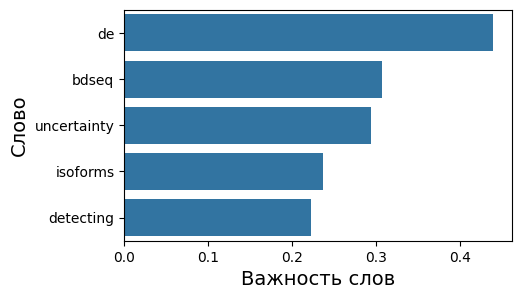

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(x=values, y=labels)
plt.xlabel('Важность слов', fontsize=14)
plt.ylabel('Слово', fontsize=14)
# plt.title('', fontsize=16)
plt.show()

In [ ]:
top_k = value_df['top_keywords'][1]

In [ ]:
top_k

[('swa', 0.323),
 ('residue', 0.305),
 ('loop', 0.241),
 ('stepwise', 0.233),
 ('modeling', 0.182)]

In [ ]:
labels, values = zip(*top_k)

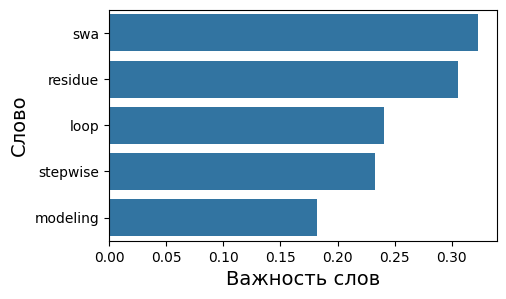

In [ ]:
plt.figure(figsize=(5, 3))
sns.barplot(x=values, y=labels)
plt.xlabel('Важность слов', fontsize=14)
plt.ylabel('Слово', fontsize=14)
# plt.title('', fontsize=16)
plt.show()